# Energy plane FEE

### Detailed model of the PMT plane front-end electronics

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

In [5]:
import system_of_units as units

In [6]:
import time

In [46]:
import FEE as FE

In [8]:
import tables

In [9]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [10]:
import fit_library as fit

## Revised on:

In [48]:
print(time.strftime("%d/%m/%Y"))

30/10/2016


In [49]:
print(time.strftime("%H:%M:%S"))

19:23:30


In [50]:
!pep8 ../Sierpe/FEE.py

In [51]:
!pyflakes ../Sierpe/FEE.py

### SPE

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

#### SPE instance

In [52]:
spe = FE.SPE(pmt_gain=4.5e6)

In [53]:
spe


        (PMT gain = 4.5e+06, slope =  5.00 ns, flat =  1.00 ns)
        

### SPE functions

1. spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns): generates a spe pulse between t0 and tmax in units of t_step
2. def spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, time_step=1*units.ns): 
   generates a train of spe pulses between signal_start and (start+ length), in the window daq_window
   
3. spe_pulse_from_vector(spe,cnt): Returns a train of SPE pulses corresponding to vector cnt

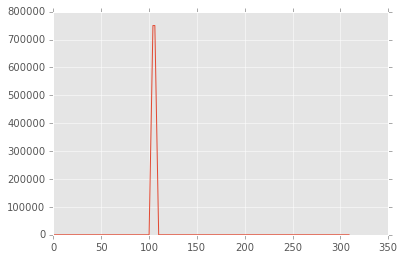

In [54]:
plt.plot(FE.spe_pulse(spe,t0=100*units.ns, tmax=300*units.ns))

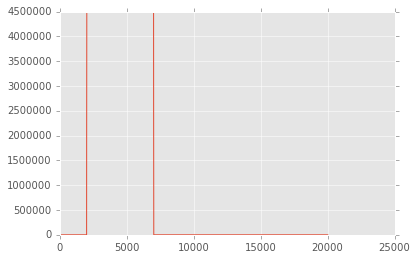

In [55]:
plt.plot(FE.spe_pulse_train(spe,signal_start=2000*units.ns,signal_length=5000*units.ns, daq_window=20*units.mus))

In [56]:
cnt = np.random.poisson(5, 10000)

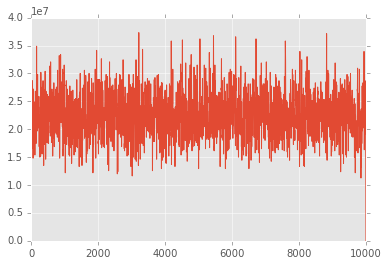

In [57]:
plt.plot(FE.spe_pulse_from_vector(spe,cnt))

## Full FEE model

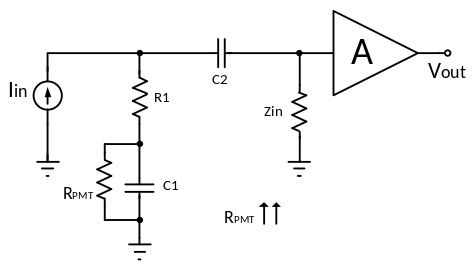

In [58]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "FEE_PMT.png")

## ==== NOISE MODEL (PMT AND FEE are combined) ====

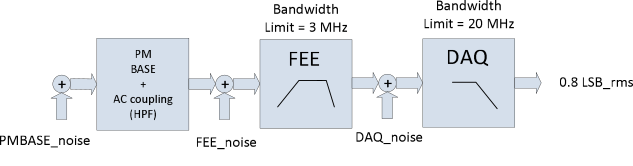

In [59]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "NOISE.png")

$$ GAIN=FEE_{GAIN} \times DAQ_{GAIN} $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = v_{DAQnoise}^{2}(out) + v_{FEE+PMBnoise}^{2}(out) $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = \int_{0}^{BW=3MHz}{v_{FEE+PMBnoise}^{2} \times {\lvert}GAIN.H(jw){\rvert}^2}  + \int_{0}^{BW=20MHz}{v_{DAQnoise}^{2} \times {\lvert}DAQ_{GAIN}.H(jw){\rvert}^2} $$
$$ $$
$$ vo_{TOTAL_{noise(rms)}} = \sqrt{vo_{TOTAL_{noise}}^{2}} = 0.76LSB_{rms}$$

### MEASURED NOISE 
$$ v_{DAQnoise}^{2}(out) = 0.64 ~LSB_{rms} = 0.3136 ~mV_{rms} $$
$$ v_{FEE+PMBnoise}^{2}(out) = 0.41 ~LSB_{rms} = ~0.2009 ~mV_{rms} $$

In [60]:
MEASURED_GAIN = 582.237
DAQ_GAIN = 1.25
SPE = 20
print "SPE (iLSB_ADC)= ", SPE



SPE (iLSB_ADC)=  20


### FEE instance (no noise)

In [63]:
feep = FE.FEE(gain=MEASURED_GAIN*units.ohm, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=0*units.mA, nbits=12, DAQnoise_rms=0)

In [64]:
feep


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.00 muA,
         NIBTS = 12,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =       0
        )
        

### FEE functions

1. i_to_adc(fee): conversion from current to adc counts
2. i_to_v(fee): conversion from current to voltage
3. noise_adc(fee): noise outuput in adc counts

In [67]:
FE.i_to_adc(feep)*100*units.mA

0.149052672

In [70]:
FE.i_to_v(feep)*units.muA/units.mV

0.5822369999999999

### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [71]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

## FEE filters

In [72]:
b,a = FE.filter_fee(feep)

In [73]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  1.05834516e+01   4.23338687e+01   5.29175691e+01   6.22138897e-04
  -5.29166359e+01  -4.23334954e+01  -1.05833894e+01] ohm


In [74]:
print("f_sample = {} Mhz".format(feep.f_sample/units.MHZ))

f_sample = 40.0 Mhz


In [75]:
def plot_filter(a,b, size_x=10, size_y=10):
    """
    Plots the filter
    """
    b = b/units.ohm
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6.5,0.4,40000)) 
    fig = plt.figure(figsize=(size_x, size_y))
    ax1 = fig.add_subplot(111)
    plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), angles,'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')

    plt.show()

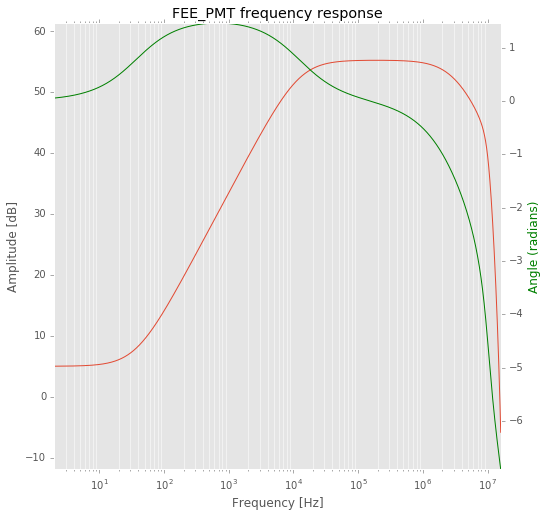

In [76]:
plot_filter(a,b,size_x=8, size_y=8)

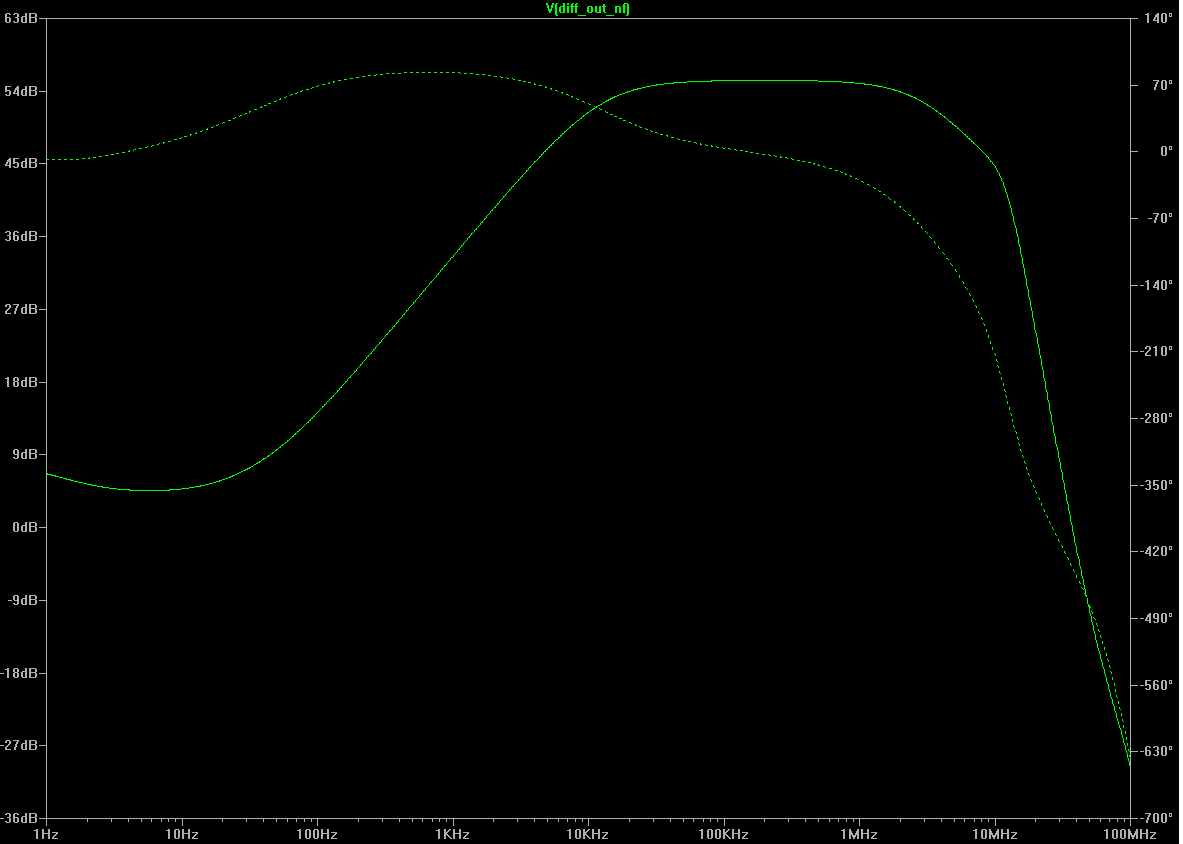

In [35]:
Image(filename = PATH + "FEE_PMT_freq_response_simulated_spice.png")

#### MATCH!!!   --VERY CLOSE TO THE SPICE SIMULATED ONE--

### =======   TEST WITHOUT NOISE   ========

In [87]:
signal_i = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [90]:
signal_out = FE.signal_v_fee(feep, signal_i)

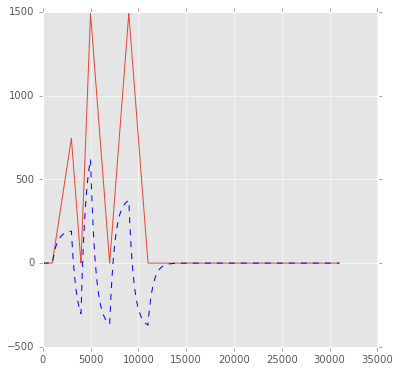

In [112]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep),'b--', linewidth=1)
plt.show()

In [113]:
print('deconvolution coefficient = {}'.format(feep.freq_LHPFd*np.pi))

deconvolution coefficient = 0.00192400951255


In [123]:
signal_r, acum = deconv_simple(signal_out*FE.v_to_adc(feep),coef=feep.freq_LHPFd*np.pi)

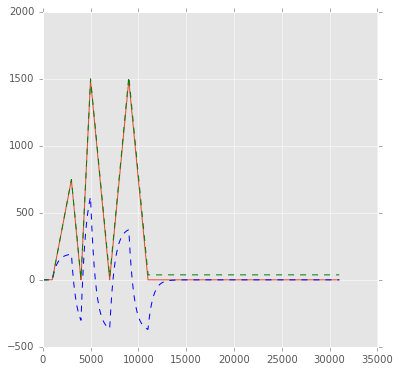

In [124]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep),'b--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r,'g--', linewidth=1)
plt.show()

In [125]:
energy_mea=np.sum(signal_r[1000:11000])
energy_in=np.sum(signal_i*FE.i_to_adc(feep))
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 6334738.56
Reconstructed Energy = 6499097.56906
Error in Energy Computation (%) = -2.5945665713


## DECONVOLUTION USING CLEANING FILTER + BLR

In [127]:
signal_out_cf = FE.signal_v_clean(feep, signal_out)

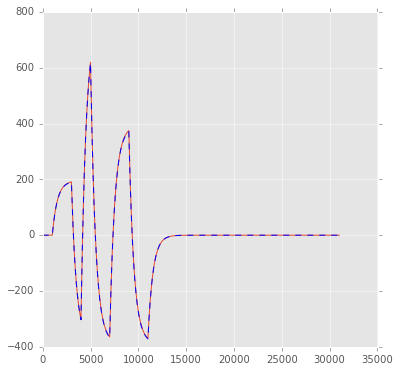

In [128]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep), linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_out_cf*FE.v_to_adc(feep),'b--', linewidth=1)
plt.show()

In [129]:
signal_r2, acum = deconv_simple(signal_out_cf*FE.v_to_adc(feep),coef=feep.freq_LHPFd*np.pi)

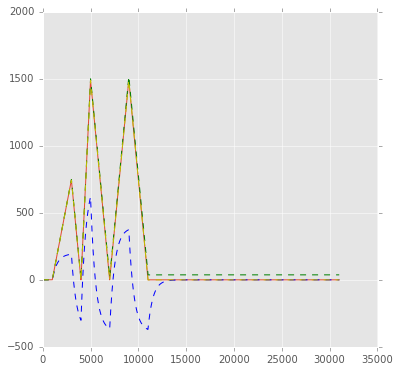

In [130]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep),'b--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r,'g--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r2,'y--', linewidth=1)
plt.show()

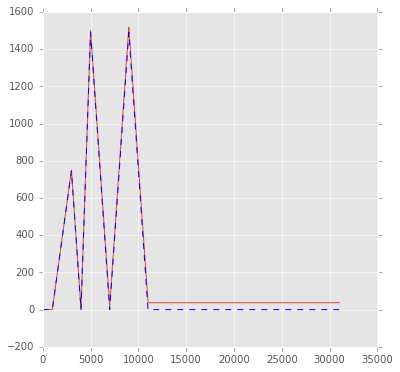

In [131]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_r, linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r2,'b--', linewidth=1)
plt.show()

In [133]:
energy_mea2=np.sum(signal_r2[1000:11000])
energy_in2=np.sum(signal_i*FE.i_to_adc(feep))
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6334918.78314
Error in Energy Computation (%) = -0.00284499725187


## ======  TEST WITH NOISE and DAQ EFFECT ======= 

In [142]:
LSB = 2*units.volt/2**12/1.25
MEASURED_GAIN = 582.237*units.ohm
DAQ_GAIN = 1.25

In [143]:
print('LSB = {} mV'.format(LSB/units.mV))

LSB = 0.390625 mV


In [144]:
lsb_ilsb = LSB/(MEASURED_GAIN*DAQ_GAIN)

In [145]:
print('LSB/(MEASURED_GAIN*DAQ_GAIN) = {} muA'.format(lsb_i/units.muA))

LSB/(MEASURED_GAIN*DAQ_GAIN) = 0.53672301829 muA


In [146]:
feepN = FE.FEE(gain=MEASURED_GAIN, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=1*lsb_i)
feepN


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         NIBTS = 12,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

In [154]:
signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [155]:
signal_outn = FE.signal_v_fee(feepN, signal_in)

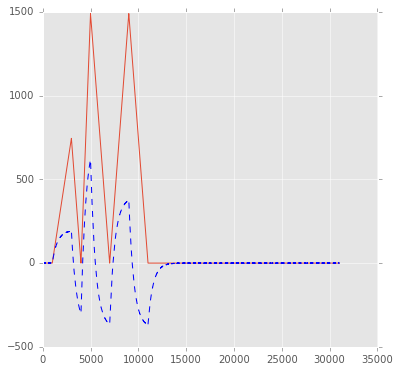

In [156]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_in),1),signal_in*FE.i_to_adc(feepN))
plt.plot(range(0,np.size(signal_in),1),signal_outn*FE.v_to_adc(feepN),'b--', linewidth=1)
plt.show()

In [160]:
print "Out Noise FEE (LSB_rms) =",np.std(signal_outn[25000:26000]*FE.v_to_adc(feepN),ddof=1)

Out Noise FEE (LSB_rms) = 0.34218700561


#### So the FEE output noise contribution matches with measurements

### Now add the DAQ contribution

In [158]:
signal_outnd = FE.noise_adc(feepN, signal_outn)

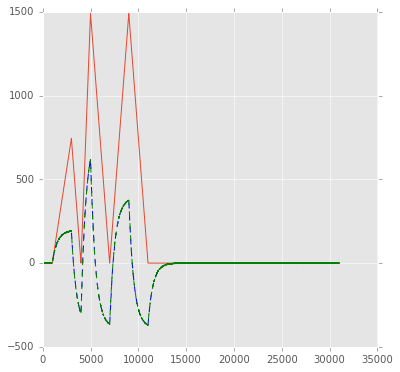

In [159]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_in),1),signal_in*FE.i_to_adc(feepN))
plt.plot(range(0,np.size(signal_in),1),signal_outn*FE.v_to_adc(feepN),'b--', linewidth=1)
plt.plot(range(0,np.size(signal_in),1),signal_outnd*FE.v_to_adc(feepN),'g--', linewidth=1)
plt.show()

In [161]:
print "Out TOTAL out noise (LSB_rms) =",np.std(signal_outnd[25000:26000]*FE.v_to_adc(feepN),ddof=1)

Out TOTAL out noise (LSB_rms) = 0.864900241585


## Reconstruct with Cleaning Filter

In [162]:
signal_out_cf2 = FE.signal_v_clean(feepN, signal_outnd)

In [165]:
signal_r3, acum = deconv_simple(signal_out_cf2*FE.v_to_adc(feepN),coef=feepN.freq_LHPFd*np.pi)

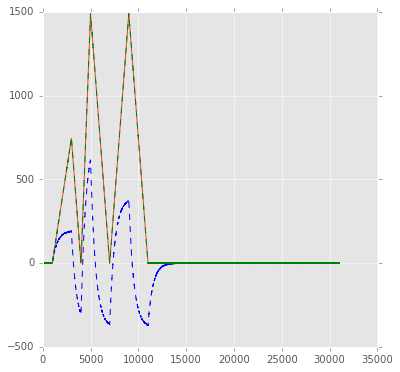

In [166]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out_cf2*FE.v_to_adc(feep),'b--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r3,'g--', linewidth=1)
plt.show()

In [167]:
energy_mea2=np.sum(signal_r3[1000:11000])
energy_in2=np.sum(signal_i*FE.i_to_adc(feepN))
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6333228.1433
Error in Energy Computation (%) = 0.0238433944344


## Statistics

In [173]:
n = 1000
recons_a = np.zeros(n)
for i in range(0,n):
    signal_outn = FE.signal_v_fee(feepN, signal_in)
    signal_outnd = FE.noise_adc(feepN, signal_outn)
    signal_out_cf2 = FE.signal_v_clean(feepN, signal_outnd)
    signal_r3, acum = deconv_simple(signal_out_cf2*FE.v_to_adc(feepN),coef=feepN.freq_LHPFd*np.pi)
    recons_a[i]=np.sum(signal_r3[1000:11000])

In [174]:
len(recons_a)

1000

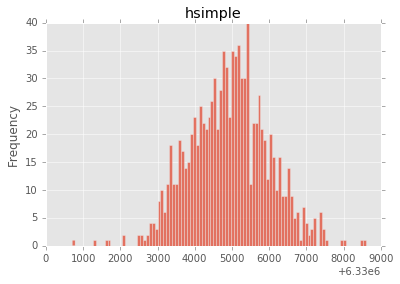

In [175]:
mpl.histo(recons_a,100)

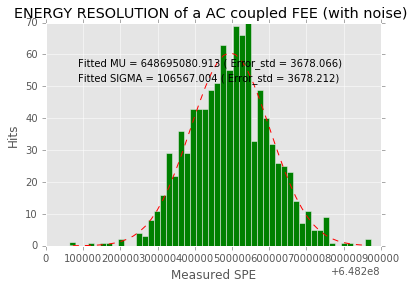

('Fitted A = ', 60.53563003309057, '( Error_std=', 1.8094155428055712, ')')
('Fitted MU = ', 648695080.91315234, '( Error_std=', 3678.0662486553101, ')')
('FItted SIGMA = ', 106567.00358914967, '( Error_std=', 3678.2116406632417, ')')
ENERGY RESOLUTION (%) =  0.0386055738363


In [176]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

## Reading  signals

#### List the files

In [73]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5


#### Open and inspect file

In [74]:
h5f = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5','r+')

In [75]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 800), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4898,), zlib(4)) ''
  

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [76]:
pmtrd = h5f.root.pmtrd

#### Plot pmtrd for the first event, first PMT

<IPython.core.display.Javascript object>


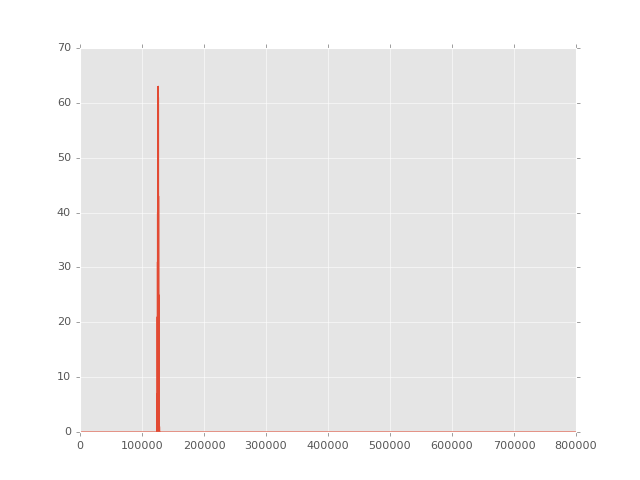

In [77]:
plt.plot(pmtrd[0,0])

<IPython.core.display.Javascript object>


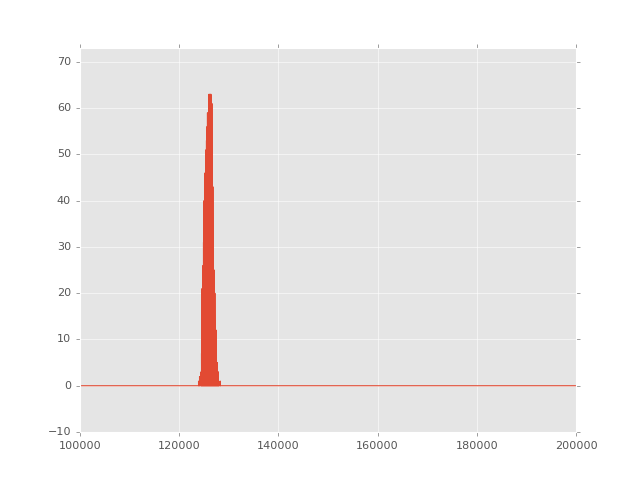

In [78]:
mpl.plts(pmtrd[0,0], signal_start=100000, signal_end=200000, offset=10)

### Convolve with the FEE

In [79]:
pmtrwf = FEE.signal_fee(sfe,pmtrd[0,0])

<IPython.core.display.Javascript object>


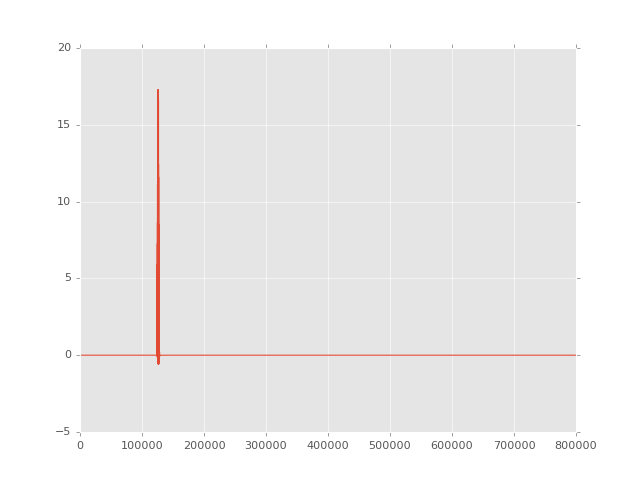

In [80]:
plt.plot(pmtrwf)

<IPython.core.display.Javascript object>


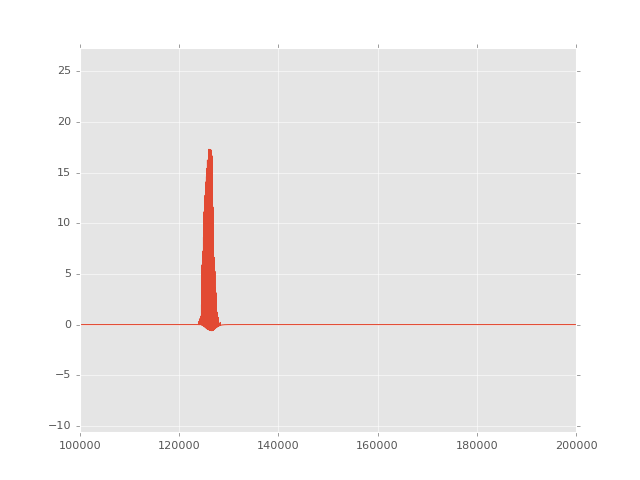

In [81]:
mpl.plts(pmtrwf, signal_start=100000, signal_end=200000, offset=10)

#### NB: With the new parameters the effect of the electronics in the short kripton signals appears small!

### Talium source

In [82]:
h5f_tl = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_10000.root.h5','r+')

In [83]:
pmtrd = h5f_tl.root.pmtrd

<IPython.core.display.Javascript object>


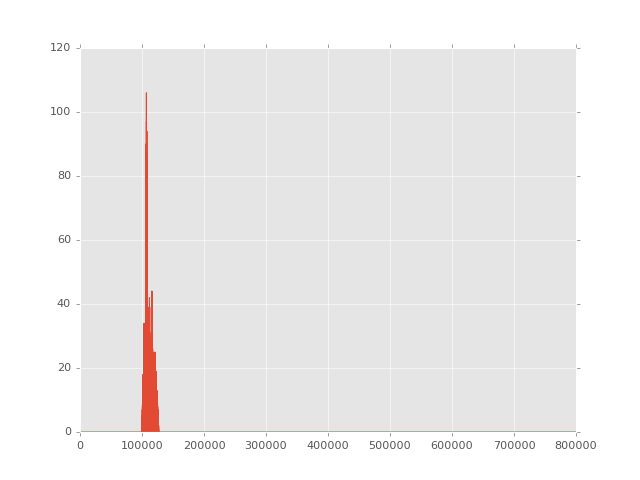

In [85]:
plt.plot(pmtrd[0,0])

<IPython.core.display.Javascript object>


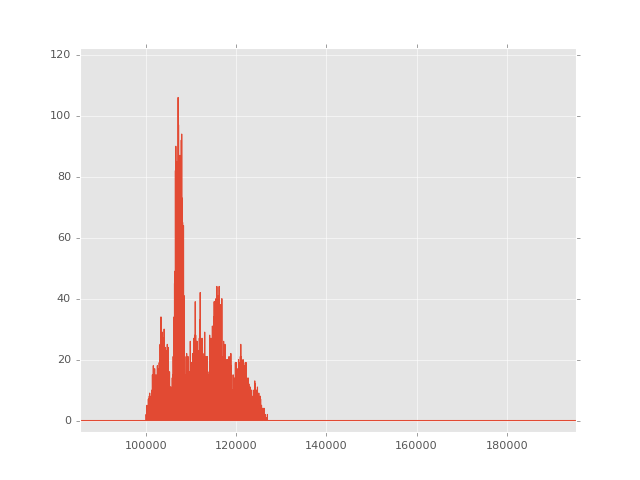

In [87]:
mpl.plts(pmtrd[0,0], signal_start=90000, signal_end=200000, offset=10)

In [88]:
pmtrwf = FEE.signal_fee(sfe,pmtrd[0,0])

<IPython.core.display.Javascript object>


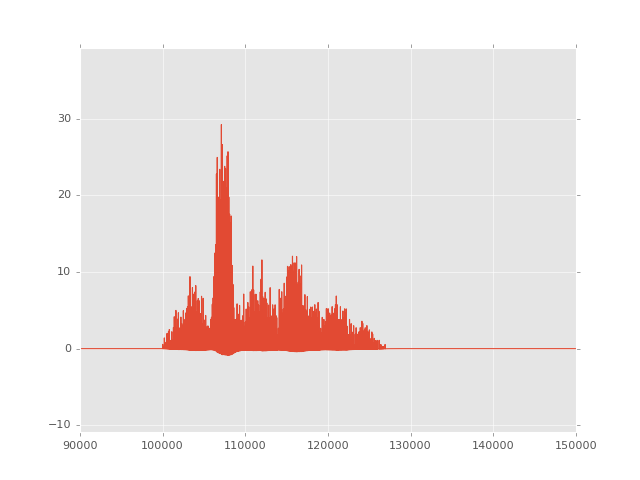

In [91]:
mpl.plts(pmtrwf, signal_start=90000, signal_end=150000, offset=10)

In [ ]:
def filter_cleaner(feep):
    """
    cleans the signal(VHB to document)
    """
    freq_zero=1/((feep.R1/units.ohm)*(feep.C1/units.farad));
    #print ('Zero(Hz) =',freq_zero/(2*np.pi));
    freq_zerod= freq_zero / ((feep.f_sample/units.hertz)*np.pi);
    #print ('Zero(rad/sec) =',freq_zero,'// (half-cycles/sample) =',freq_zerod)

    b, a = signal.butter(1, freq_zerod, 'high', analog=False);

    return b, a

In [94]:
R1 = 10*units.ohm
C1 = 5*units.farad
fz = 1./((R1/units.ohm)*(C1/units.farad))
fs = 100*np.pi/units.hertz
print(fz/fs)
f2z = 1./(R1*C1)
f2s = 100*np.pi
print(f2z/f2s)

6.36619772368e-14
6.36619772368e-14
